### Simulate capital requirements for hypothetical scenarios

#### Goal

The main aim was to see how using different levels of aggregation in credit ratings affects the calculation of Risk-Weighted Assets (RWA) for a portfolio of retail exposures, especially under stressed economic conditions. We compared results using the non-aggregated ratings (like AA+, AA, AA-) against broader categories (like AA).

#### Process Overview

We started with a table summarizing retail exposures by their detailed credit rating, including the number of borrowers and their average Probability of Default (PD).

First, we expanded this summary data to create a large dataset representing thousands of individual simulated exposures, giving each one the characteristics (like PD, LGD, EAD) appropriate for its original detailed rating category. We also simulated which of these exposures might default.

Next, we calculated the RWA for every single exposure using two different methods:

1.  **Detailed Method:** Used the specific PD associated with the original detailed rating (e.g., AA+, AA, AA-).
2.  **Aggregated Method:** Calculated an average PD for broader rating groups (e.g., all AA variants averaged together) and then used *that* average PD for all exposures within that group.

We repeated both methods under normal conditions (Base PD) and also under two stress scenarios where the PDs were artificially increased (1.5x PD and 2.0x PD).

Finally, to compare the overall impact, we calculated the *total portfolio risk weight* for each of the six scenarios (Detailed/Aggregated x Base/1.5x/2.0x PD). This risk weight is simply the Total RWA of all exposures divided by their Total EAD.

#### Output

The results were presented in a bar chart showing the six overall portfolio risk weights side-by-side, making it easy to visually compare how much the RWA changes depending on the level of rating detail used and the severity of the PD stress applied.

Detailed RWA calculation finished.
Aggregated RWA calculation finished.


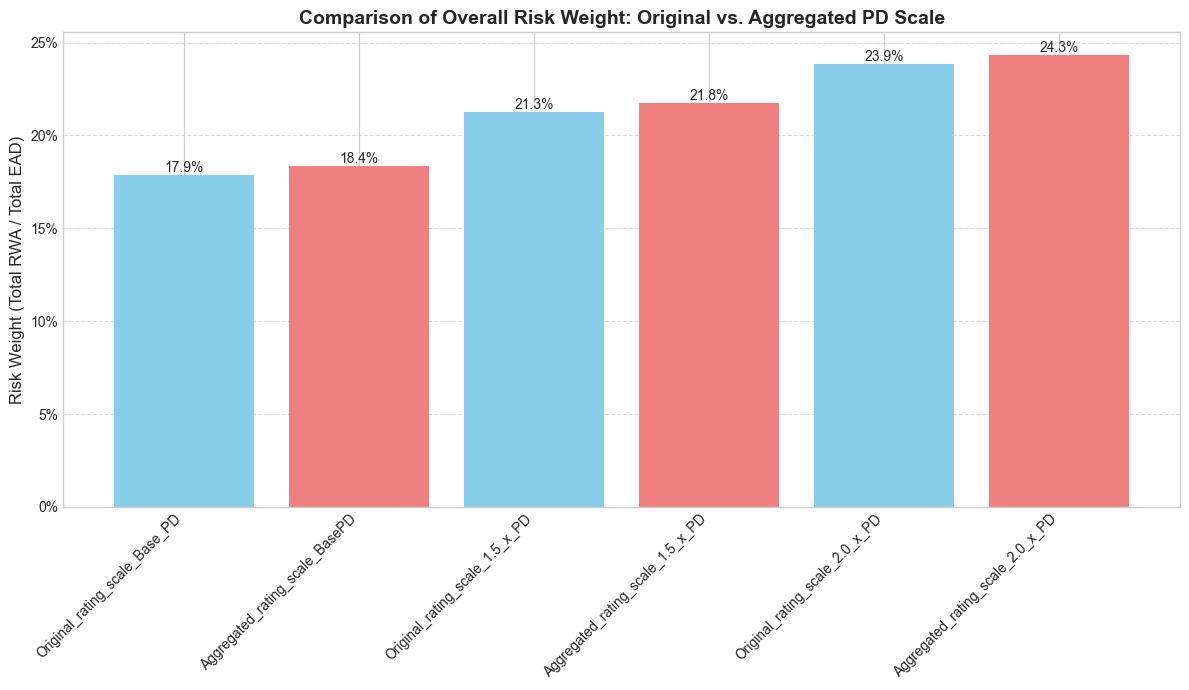

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # Import ticker for percentage formatting

# --- Data Setup ---
data = [
    ['0.00 - 0.01', 'AAA', 2090723, 1136, 0.05, 0.03, 0.06],
    ['0.01 - 0.02', 'AA+', 817666, 885, 0.11, 0.03, 0.14],
    ['0.02 - 0.03', 'AA', 32152, 35, 0.11, 0.03, 0.07],
    ['0.03 - 0.04', 'AA-', 632163, 663, 0.10, 0.04, 0.13],
    ['0.04 - 0.05', 'A+', 17587, 34, 0.19, 0.06, 0.11],
    ['0.05 - 0.07', 'A', 12083, 17, 0.14, 0.08, 0.10],
    ['0.07 - 0.11', 'A-', 211076, 515, 0.24, 0.10, 0.18],
    ['0.11 - 0.17', 'BBB+', 991989, 2363, 0.24, 0.13, 0.24],
    ['0.17 - 0.27', 'BBB', 392173, 1251, 0.32, 0.24, 0.25],
    ['0.27 - 0.44', 'BBB-', 253203, 1377, 0.54, 0.34, 0.54],
    ['0.44 - 0.73', 'BB+', 336017, 21679, 6.45, 0.50, 5.26],
    ['0.73 - 1.26', 'BB', 314662, 2805, 0.89, 0.77, 0.78],
    ['1.26 - 2.24', 'BB-', 486124, 13351, 2.75, 1.51, 2.13],
    ['2.24 - 4.09', 'B+', 420977, 7464, 1.77, 2.58, 1.55],
    ['4.09 - 7.66', 'B', 101839, 3977, 3.91, 4.07, 4.21],
    ['7.66 - 14.78', 'B-', 81777, 6602, 8.07, 8.30, 8.65],
    ['14.78 - 22.73', 'CCC', 40608, 6642, 16.36, 16.61, 13.04],
    ['22.73 - 29.58', 'CC', 2058, 655, 31.83, 29.23, 29.23],
    ['29.58 - 100.00', 'C', 19097, 4471, 23.41, 36.41, 32.34]
]
df = pd.DataFrame(data, columns=['PD Range', 'External rating equivalent', 'number of obligors',
                                   'of which: number of obligors which defaulted during the year',
                                   'Observed average default rate (%)', 'Average PD (%)',
                                   'Average historical annual default (%)'])
df['n_obs'] = (df['number of obligors'] / 1000).astype(int)
df_summary = df[['External rating equivalent', 'Average PD (%)', 'Average historical annual default (%)', 'n_obs']].copy()
df_summary.rename(columns={'External rating equivalent': 'rating',
                          'Average PD (%)': 'average PD',
                          'Average historical annual default (%)': 'average historical annual PD'}, inplace=True)

# --- Expansion Step ---
expanded_df = df_summary.loc[df_summary.index.repeat(df_summary['n_obs'])]
expanded_df = expanded_df[['rating', 'average PD', 'average historical annual PD']]
expanded_df = expanded_df.reset_index(drop=True)
expanded_df['ID'] = expanded_df.index

# --- Add Default Flag ---
np.random.seed(42)
probabilities = expanded_df['average PD'] / 100.0
random_draws = np.random.rand(len(expanded_df))
expanded_df['default'] = (random_draws <= probabilities).astype(int)

# --- Define Original Rating Order and Convert to Categorical ---
rating_order = [
    'AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-',
    'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-',
    'B+', 'B', 'B-', 'CCC', 'CC', 'C'
]
expanded_df['rating'] = pd.Categorical(expanded_df['rating'], categories=rating_order, ordered=True)

# --- Create New Rating Group using Dictionary and Map ---
rating_map_dict = {
    'AAA': 'AAA', 'AA+': 'AA', 'AA':  'AA', 'AA-': 'AA', 'A+':  'A', 'A':   'A',
    'A-':  'A', 'BBB+': 'BBB', 'BBB':  'BBB', 'BBB-': 'BBB', 'BB+': 'BB', 'BB':  'BB',
    'BB-': 'BB', 'B+':  'B', 'B':   'B', 'B-':  'B', 'CCC': 'CCC', 'CC':  'CC', 'C': 'C'
}
expanded_df['rating_group'] = expanded_df['rating'].map(rating_map_dict)
rating_group_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C']
expanded_df['rating_group'] = pd.Categorical(expanded_df['rating_group'], categories=rating_group_order, ordered=True)

# --- Sort the DataFrame ---
expanded_df = expanded_df.sort_values('rating')
expanded_df = expanded_df.reset_index(drop=True)

# --- Add LGD, EAD, Stressed PDs (Percentages) for Detailed Scale ---
expanded_df['LGD'] = 0.39
expanded_df['EAD'] = 1000.0
expanded_df['PD_base_perc'] = expanded_df['average PD']
expanded_df['PD_1.5x_perc'] = expanded_df['average PD'] * 1.5
expanded_df['PD_2.0x_perc'] = expanded_df['average PD'] * 2.0

# --- Define EXACT User-Provided RWA Calculation Function ---
def calculate_RWA(exposure_type, PD, LGD, EAD, add_on=1.06, M=None, S=None):
    assert 0 <= PD <= 1, f"PD must be between 0 and 1. Got: {PD}"
    assert 0 <= LGD <= 1, "LGD must be between 0 and 1."
    if M is not None: M = np.clip(M, 1, 5)
    if S is not None: S = np.clip(S, 5, 50)

    def G(z):
        z_clipped = np.clip(z, 1e-9, 1.0 - 1e-9)
        return norm.ppf(z_clipped)

    if exposure_type == "Residential Mortgages": R = 0.15
    elif exposure_type == "Qualifying Revolving Retail Exposures": R = 0.04
    elif exposure_type == "Other Retail Exposures":
        PD_clipped_R = np.clip(PD, 1e-9, 1.0 - 1e-9); exp_term = np.exp(-35 * PD_clipped_R); denominator = (1 - np.exp(-35))
        ratio = (1 - exp_term) / denominator if not np.isclose(denominator, 0) else (0 if PD_clipped_R == 0 else 1)
        R = 0.03 * ratio + 0.16 * (1 - ratio)
    elif exposure_type == "Corporate Exposures":
        PD_clipped_R = np.clip(PD, 1e-9, 1.0 - 1e-9); exp_term = np.exp(-50 * PD_clipped_R); denominator = (1 - np.exp(-50))
        ratio = (1 - exp_term) / denominator if not np.isclose(denominator, 0) else (0 if PD_clipped_R == 0 else 1)
        R_base = 0.12 * ratio + 0.24 * (1 - ratio)
        R = R_base - 0.04 * (1 - (S - 5) / 45) if S is not None else R_base
    else: return np.nan

    if exposure_type == "Corporate Exposures":
        PD_clipped_K = np.clip(PD, 1e-9, 1.0 - 1e-9); b = (0.11852 - 0.05478 * np.log(PD_clipped_K)) ** 2
        if M is None: raise ValueError("Maturity (M) must be provided for Corporate Exposures.")
        K = (LGD * norm.cdf(np.sqrt((1 - R)**-1) * G(PD) + np.sqrt(R / (1 - R)) * G(0.999)) - PD * LGD) * (1 - 1.5 * b) ** -1 * (1 + (M - 2.5) * b)
    else: K = LGD * norm.cdf(((1 - R)**-0.5) * G(PD) + (R / (1 - R)) ** 0.5 * G(0.999)) - PD * LGD
    K = max(K, 0)
    RWA = K * 12.5 * EAD * add_on
    return RWA

# --- Calculate RWA ---
exposure_type = 'Other Retail Exposures'
expanded_df['RWA_detailed_base'] = expanded_df.apply(lambda row: calculate_RWA(
    exposure_type=exposure_type, 
    PD=np.clip(row['PD_base_perc'] / 100.0, 0.0, 1.0), 
    LGD=row['LGD'], 
    EAD=row['EAD']), 
    axis=1
)
expanded_df['RWA_detailed_1.5x'] = expanded_df.apply(lambda row: calculate_RWA(
    exposure_type=exposure_type, 
    PD=np.clip(row['PD_1.5x_perc'] / 100.0, 0.0, 1.0), 
    LGD=row['LGD'], 
    EAD=row['EAD']), 
    axis=1
)
expanded_df['RWA_detailed_2.0x'] = expanded_df.apply(lambda row: calculate_RWA(
    exposure_type=exposure_type, 
    PD=np.clip(row['PD_2.0x_perc'] / 100.0, 0.0, 1.0), 
    LGD=row['LGD'], 
    EAD=row['EAD']), 
    axis=1)
print("Detailed RWA calculation finished.")

# --- Calculate and Map AGGREGATED PDs ---
def summarize_rating_groups(df, group_col='rating_group', pd_col='average PD', weight_col='EAD'):
    is_categorical = isinstance(df[group_col].dtype, pd.CategoricalDtype)
    grouped = df.groupby(group_col, observed=is_categorical)
    summary = grouped.agg(Total_EAD=(weight_col, 'sum'), Average_PD_percent=(pd_col, 'mean'))
    summary = summary.rename(columns={'Average_PD_percent': f'Average {pd_col} (%)'})
    summary = summary.reset_index()
    return summary

grouped_pd_summary_final = summarize_rating_groups(expanded_df, pd_col='PD_base_perc')
expanded_df = pd.merge(expanded_df, grouped_pd_summary_final[['rating_group', 'Average PD_base_perc (%)']], on='rating_group', how='left')
expanded_df.rename(columns={'Average PD_base_perc (%)': 'agg_PD_base_perc'}, inplace=True)
expanded_df['agg_PD_1.5x_perc'] = expanded_df['agg_PD_base_perc'] * 1.5
expanded_df['agg_PD_2.0x_perc'] = expanded_df['agg_PD_base_perc'] * 2.0

# --- Calculate RWA for AGGREGATED PDs ---
expanded_df['RWA_agg_base'] = expanded_df.apply(lambda row: calculate_RWA(exposure_type=exposure_type, PD=np.clip(row['agg_PD_base_perc'] / 100.0, 0.0, 1.0), LGD=row['LGD'], EAD=row['EAD']), axis=1)
expanded_df['RWA_agg_1.5x'] = expanded_df.apply(lambda row: calculate_RWA(exposure_type=exposure_type, PD=np.clip(row['agg_PD_1.5x_perc'] / 100.0, 0.0, 1.0), LGD=row['LGD'], EAD=row['EAD']), axis=1)
expanded_df['RWA_agg_2.0x'] = expanded_df.apply(lambda row: calculate_RWA(exposure_type=exposure_type, PD=np.clip(row['agg_PD_2.0x_perc'] / 100.0, 0.0, 1.0), LGD=row['LGD'], EAD=row['EAD']), axis=1)
print("Aggregated RWA calculation finished.")

# --- Calculate Overall Risk Weights for Comparison ---
total_ead = expanded_df['EAD'].sum()
results = {}
results['Original_rating_scale_Base_PD'] = expanded_df['RWA_detailed_base'].sum() / total_ead
results['Aggregated_rating_scale_BasePD'] = expanded_df['RWA_agg_base'].sum() / total_ead
results['Original_rating_scale_1.5_x_PD'] = expanded_df['RWA_detailed_1.5x'].sum() / total_ead
results['Aggregated_rating_scale_1.5_x_PD'] = expanded_df['RWA_agg_1.5x'].sum() / total_ead
results['Original_rating_scale_2.0_x_PD'] = expanded_df['RWA_detailed_2.0x'].sum() / total_ead
results['Aggregated_rating_scale_2.0_x_PD'] = expanded_df['RWA_agg_2.0x'].sum() / total_ead
plot_data = pd.DataFrame(list(results.items()), columns=['Scenario', 'Overall Risk Weight'])

# --- Create Comparison Plot with Percentage Formatting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

scenarios = plot_data['Scenario']
risk_weights = plot_data['Overall Risk Weight']
bar_locations = np.arange(len(scenarios))

bars = ax.bar(bar_locations, risk_weights, color=['skyblue', 'lightcoral', 'skyblue', 'lightcoral', 'skyblue', 'lightcoral'])

ax.set_ylabel('Risk Weight (Total RWA / Total EAD)', fontsize=12)
ax.set_title('Overall Risk Weight: Original vs. Aggregated PD Scale', fontsize=14, fontweight='bold')
ax.set_xticks(bar_locations)
ax.set_xticklabels(scenarios, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars (formatted as percentage)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval*100:.1f}%', va='bottom', ha='center', fontsize=10)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0)) # xmax=1.0 because data is 0-1

plt.ylim(bottom=0)
plt.tight_layout()
plt.show()